<a href="https://colab.research.google.com/github/misganablue/MDAnalysis_Lobetyolin-TR/blob/main/Final_MD_Lobetyolin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect to Google Drive & Set working environmen

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to where your files are stored
import os
os.chdir('/content/drive/My Drive/MD_Lobetyolin_1BZL')  # Adjust path as necessary

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installation of  all required packages on Google Colab

In [3]:
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

  Using cached condacolab-0.1.10-py3-none-any.whl.metadata (5.5 kB)
Using cached condacolab-0.1.10-py3-none-any.whl (7.2 kB)
✨🍰✨ Everything looks OK!


In [4]:
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj openmm openmmforcefields pdbfixer pypdb rdkit
    on_colab = True
    clear_output()  # clear the excessive installation outputs
    print("Dependencies successfully installed!")
except ModuleNotFoundError:
    on_colab = False

Dependencies successfully installed!


In [5]:
# imports
import sys
import copy
from pathlib import Path

from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from pypdb import get_pdb_file
import mdtraj as md
import pdbfixer
import simtk.openmm as mm
import simtk.openmm.app as app
from simtk.openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


Prepare the protein ligand complex

In [ ]:
import os

# Define the file path for your protein structure
file_directory = "/content/drive/My Drive/MD_Lobetyolin_1BZL"  # Update this to your directory
protein_structure = os.path.join(file_directory, "1BZL_modified.pdb")

# Define the ligand name
ligand_name = "LIG"

# Check if the file exists
if not os.path.exists(protein_structure):
    raise FileNotFoundError(f"The PDB file '{protein_structure}' does not exist!")

# Read the PDB file
with open(protein_structure, 'r') as f:
    pdb_file_string = f.read()

# Filter out only lines related to the ligand and protein
protein_ligand_lines = []
for line in pdb_file_string.splitlines():
    if line.startswith("ATOM") or (line.startswith("HETATM") and ligand_name in line):
        protein_ligand_lines.append(line)

print("PDB file accessed and processed successfully!")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PDB file accessed and processed successfully!


Protein preparation

In [ ]:
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

def prepare_protein(pdb_file, output_file, ignore_missing_residues=False, ignore_terminal_missing_residues=True):
    """
    Prepare the protein using pdbfixer. Heteroatoms such as ligands are removed,
    non-standard residues are replaced, and missing atoms are added. Only non-terminal missing residues are rebuilt.

    Parameters
    ----------
    pdb_file : str
        Path to the input PDB file containing the protein to prepare.
    output_file : str
        Path to save the prepared PDB file.
    ignore_missing_residues : bool
        If False, rebuilds non-terminal missing residues. Default is False.
    ignore_terminal_missing_residues : bool
        If True, ignores terminal missing residues. Default is True.
    """
    # Load the PDB file
    fixer = PDBFixer(filename=pdb_file)

    # Remove heteroatoms
    fixer.removeHeterogens()

    # Find and handle missing residues
    fixer.findMissingResidues()
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = list(fixer.missingResidues.keys())
        for key in keys:
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):  # First or last residue
                del fixer.missingResidues[key]

    if ignore_missing_residues:
        fixer.missingResidues = {}

    # Replace non-standard residues and add missing atoms
    fixer.findNonstandardResidues()
    fixer.replaceNonstandardResidues()
    fixer.findMissingAtoms()
    fixer.addMissingAtoms()
    fixer.addMissingHydrogens(7.0)

    # Save the prepared protein to a file
    with open(output_file, 'w') as f:
        PDBFile.writeFile(fixer.topology, fixer.positions, f, keepIds=True)

# Paths to the input and output files
protein_file = "/content/drive/My Drive/MD_Lobetyolin_1BZL/1BZL_modified.pdb"
prepared_protein_file = "/content/drive/My Drive/MD_Lobetyolin_1BZL/1BZL_modified_prepared.pdb"

# Run the protein preparation with non-terminal residue building
prepare_protein(protein_file, prepared_protein_file, ignore_missing_residues=False)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define the path to your protein PDB file
pdb_path = "/content/drive/My Drive/MD_Lobetyolin_1BZL/1BZL_modified.pdb"

# Define the path to save the prepared protein structure
output_file = "/content/drive/My Drive/MD_Lobetyolin_1BZL/1BZL_modified_prepared.pdb"

# Ensure the prepare_protein function is defined or imported
# Then prepare the protein
prepared_protein = prepare_protein(pdb_path, output_file, ignore_missing_residues=False)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Prepare ligand

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import copy
from IPython.display import display

def prepare_ligand(pdb_file, resname, smiles):
    """
    Prepare a ligand from a PDB file by adding hydrogens and assigning bond orders.
    Depictions of the ligand before and after preparation are rendered in 2D for inspection.

    Parameters
    ----------
    pdb_file : str or pathlib.PosixPath
        Path to the PDB file containing the ligand of interest.
    resname : str
        Three-character residue name of the ligand to identify it within the PDB file.
    smiles : str
        SMILES string of the ligand specifying correct protonation and bond orders.

    Returns
    -------
    prepared_ligand : rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """
    # Load the molecule from the PDB file
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file), sanitize=False)
    if rdkit_mol is None:
        raise ValueError(f"Could not load molecule from PDB file: {pdb_file}")

    # Split the molecule into residues
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)
    if resname not in rdkit_mol_split:
        raise ValueError(f"Residue name '{resname}' not found in the PDB file.")

    # Extract the ligand and remove hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand, sanitize=False)

    # Assign bond orders using the SMILES template
    reference_mol = Chem.MolFromSmiles(smiles)
    if reference_mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)

    # Transfer 3D coordinates to the prepared ligand
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # Protonate the ligand and add 3D hydrogens
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)

    # Generate 2D depictions for comparison
    ligand_2d = copy.deepcopy(ligand)
    prepared_ligand_2d = copy.deepcopy(prepared_ligand)
    AllChem.Compute2DCoords(ligand_2d)
    AllChem.Compute2DCoords(prepared_ligand_2d)
    display(
        Draw.MolsToGridImage(
            [ligand_2d, prepared_ligand_2d],
            molsPerRow=2,
            legends=["Original Ligand", "Prepared Ligand"]
        )
    )

    return prepared_ligand


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


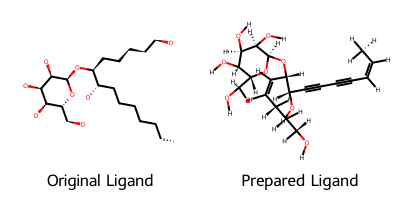

In [ ]:
smiles = "OCC1C(O)C(O)C(O)C(OC(/C=C/CCCO)C(O)C#CC#C/C=C/C)O1"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)
# NBVAL_CHECK_OUTPUT

Merge protein and ligand

In [ ]:
from rdkit import Chem
from openff.toolkit.topology import Molecule
from simtk.openmm import app
from openmm import unit

def rdkit_to_openmm(smiles, name="LIG"):
    """Convert a SMILES string to an OpenMM molecule and generate 3D coordinates."""
    rdkit_mol = Chem.MolFromSmiles(smiles)
    off_mol = Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
    off_mol.name = name

    # Generate 3D coordinates for the ligand
    off_mol.generate_conformers(n_conformers=1)

    if len(off_mol.conformers) == 0:
        raise ValueError("Failed to generate 3D conformers for the ligand.")

    # Create OpenMM topology and positions from OpenFF molecule
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    mol_positions = unit.Quantity(mol_positions, unit.angstrom)
    mol_positions = mol_positions.in_units_of(unit.nanometer)

    omm_mol = app.Modeller(mol_topology, mol_positions)

    # Rename the ligand to 'LIG' explicitly
    for residue in omm_mol.topology.residues():
        if residue.name != 'LIG':  # Renaming to LIG if not already named as LIG
            residue.name = 'LIG'

    return omm_mol

# Path to your prepared protein PDB file
protein_pdb = '/content/drive/My Drive/MD_Lobetyolin_1BZL/1BZL_modified_prepared.pdb'

# Read the protein structure
protein = app.PDBFile(protein_pdb)

# Ligand SMILES string
ligand_smiles = "OCC1C(O)C(O)C(O)C(OC(/C=C/CCCO)C(O)C#CC#C/C=C/C)O1"

# Convert the ligand to OpenMM
ligand_mol = rdkit_to_openmm(ligand_smiles, name="LIG")

# Create a modeller object for the complex
modeller = app.Modeller(protein.topology, protein.positions)

# Add the ligand to the protein structure
modeller.add(ligand_mol.topology, ligand_mol.positions)

# Save the protein-ligand complex to a new PDB file
output_pdb = '/content/drive/My Drive/MD_Lobetyolin_1BZL/protein_ligand_complex.pdb'
with open(output_pdb, 'w') as f:
    app.PDBFile.writeFile(modeller.topology, modeller.positions, f)

print(f"Protein-ligand complex saved to {output_pdb}")



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/site-packages/openmm/app/pdbfile.py:347: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  positions = np.asarray(positions)


Protein-ligand complex saved to /content/drive/My Drive/MD_Lobetyolin_1BZL/protein_ligand_complex.pdb


Solvation of the Protein-Ligand Complex

In [ ]:
from openmm.app import Modeller, PDBFile, ForceField
from openmm import unit
from openff.toolkit.topology import Molecule
from openmmforcefields.generators import GAFFTemplateGenerator

# Path to the protein-ligand complex PDB file
complex_pdb = '/content/drive/My Drive/MD_Lobetyolin_1BZL/protein_ligand_complex.pdb'

# Load the protein-ligand complex
complex_structure = PDBFile(complex_pdb)

# Create OpenMM ForceField to handle protein, solvent, and the ligand using GAFF
# Modified line: Initialize with only amber and tip3p, then register GAFF
forcefield = ForceField('amber99sb.xml', 'tip3p.xml')  # Remove 'gaff-2.11.xml'

# Create the modeller object for the complex
modeller = Modeller(complex_structure.topology, complex_structure.positions)

# Get the ligand molecule from the topology
ligand_topology = None
for residue in modeller.topology.residues():
    if residue.name == "LIG":
        ligand_topology = residue
        break

if ligand_topology is None:
    raise ValueError("Ligand residue 'LIG' not found in the topology")

# Generate GAFF parameters for the ligand:
gaff = GAFFTemplateGenerator(molecules=Molecule.from_smiles("OCC1C(O)C(O)C(O)C(OC(/C=C/CCCO)C(O)C#CC#C/C=C/C)O1", allow_undefined_stereo=True), forcefield='gaff-2.11') # Specify the forcefield name
forcefield.registerTemplateGenerator(gaff.generator)

# Now add solvent (water molecules) with padding of 1 nm
modeller.addSolvent(forcefield, model='tip3p', padding=1.0*unit.nanometers)

# Save the solvated system to a new PDB file
solvated_pdb = '/content/drive/My Drive/MD_Lobetyolin_1BZL/solvated_complex.pdb'
with open(solvated_pdb, 'w') as f:
    PDBFile.writeFile(modeller.topology, modeller.positions, f)

print(f"Solvated system saved to {solvated_pdb}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Solvated system saved to /content/drive/My Drive/MD_Lobetyolin_1BZL/solvated_complex.pdb


Set up the simulation

In [ ]:
from openmm.app import Modeller, PDBFile, ForceField, Simulation, StateDataReporter
from openmm import unit
import openmm as omm
from pathlib import Path
import mdtraj as md
from pathlib import Path
from simtk import unit
import sys
from openff.toolkit.topology import Molecule
from openmmforcefields.generators import GAFFTemplateGenerator

# Define the data directory (replace with your actual path)
DATA = Path('/content/drive/My Drive/MD_Lobetyolin_1BZL')

# Create OpenMM ForceField to handle protein, solvent, and the ligand using GAFF
forcefield = ForceField('amber99sb.xml', 'tip3p.xml')

# Generate GAFF parameters for the ligand:
gaff = GAFFTemplateGenerator(molecules=Molecule.from_smiles("OCC1C(O)C(O)C(O)C(OC(/C=C/CCCO)C(O)C#CC#C/C=C/C)O1", allow_undefined_stereo=True), forcefield='gaff-2.11') # Specify the forcefield name
forcefield.registerTemplateGenerator(gaff.generator)

# Load the solvated system - from the saved PDB file
solvated_pdb = DATA / 'solvated_complex.pdb'  # Using Path object
pdb = PDBFile(str(solvated_pdb))  # Convert Path to string for PDBFile # This line is added to define pdb

# Create the OpenMM system using the defined forcefield
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds)

# Create the integrator
integrator = omm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 0.002*unit.picoseconds)

# Create the simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Minimization of the Protein-Ligand Complex

In [ ]:
import numpy as np

# Minimize the system
print("Minimizing the system...")
simulation.minimizeEnergy()

# Get the periodic box dimensions and positions after minimization
state = simulation.context.getState(getPositions=True, enforcePeriodicBox=True)
positions = state.getPositions()
box_vectors = state.getPeriodicBoxVectors()

# Use MDTraj to wrap the positions to the periodic box
import mdtraj as md

# Convert OpenMM topology and positions to MDTraj format
topology = md.Topology.from_openmm(simulation.topology)
xyz = np.array([positions.value_in_unit(unit.nanometer)], dtype=np.float32)  # Convert positions to numpy array in float32

# Convert box vectors to the required MDTraj format (shape: [n_frames, 3, 3]) and cast to float32
unitcell_vectors = np.array(
    [[[v[0], v[1], v[2]] for v in box_vectors.value_in_unit(unit.nanometer)]],
    dtype=np.float32
)

# Create an MDTraj trajectory and assign unit cell vectors
traj = md.Trajectory(xyz, topology)
traj.unitcell_vectors = unitcell_vectors

# Wrap the positions to ensure the protein, ligand, and solvent are within the periodic box
traj.image_molecules(inplace=True)

# Update the simulation with wrapped positions
simulation.context.setPositions(traj.xyz[0] * unit.nanometer)

# Save the wrapped topology and positions to a PDB file
output_pdb = DATA / "topology.pdb"
with open(output_pdb, "w") as pdb_file:
    app.PDBFile.writeFile(simulation.topology,
                          simulation.context.getState(getPositions=True, enforcePeriodicBox=True).getPositions(),
                          file=pdb_file,
                          keepIds=True)

print(f"Minimized and wrapped topology saved to {output_pdb}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Minimizing the system...
Minimized and wrapped topology saved to /content/drive/My Drive/MD_Lobetyolin_1BZL/topology.pdb


Perform the MD simulation

In [ ]:
# Load the minimized system (topology.pdb)
minimized_pdb = DATA / 'topology.pdb'
pdb = PDBFile(str(minimized_pdb))

# Simulation settings
steps = 10000  # corresponds to 20 ps
write_interval = 1000  # write every 2 ps
log_interval = 500  # log progress to stdout every 1 ps

# Add reporters
simulation.reporters.append(md.reporters.XTCReporter(file=str(DATA / "trajectory.xtc"),
                                                     reportInterval=write_interval))
simulation.reporters.append(StateDataReporter(sys.stdout, log_interval, step=True,
                                              potentialEnergy=True, temperature=True,
                                              progress=True, remainingTime=True,
                                              speed=True, totalSteps=steps, separator='\t'))

# Set velocities and run simulation
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(steps)
print("Simulation completed!")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
5.0%	500	-1733036.6834236328	236.80878807330566	0	--
10.0%	1000	-1672054.602841552	268.5327697886884	0.355	1:12:57
15.0%	1500	-1637058.2862731318	282.67592047464325	0.357	1:08:39
20.0%	2000	-1619611.5006029273	291.0102413488859	0.354	1:05:00
25.0%	2500	-1608964.7240648295	295.0521032258345	0.354	1:01:01
30.0%	3000	-1603331.531418219	297.86025083535606	0.354	56:56
35.0%	3500	-1599087.0124130268	298.0899530849099	0.354	52:55
40.0%	4000	-1598558.9379937972	299.1701025406649	0.354	48:52
45.0%	4500	-1597108.8346993625	300.22916707382785	0.353	44:48
50.0%	5000	-1596745.3856050833	301.8601482128864	0.353	40:46
55.0%	5500	-1595809.045038243	298.925030425681	0.353	36:41
60.0%	6000	-1596763.4900724387	300.89363573662484	0.353	32:39
65.0%	6500	-1597316.8229405521	301.04894706047406	0.353	28:34
70.0%	7000	-1595293.7548677207	300.946044921773	0.353	24:29
75.0%	7500	-1596577.6234873328	300.1680171

Analyzing molecular dynamics simulations

Import dependencies

In [6]:
import os
import sys
import contextlib

# Function to suppress output
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Suppress output while installing dependencies and importing libraries
with suppress_output():
    # Install libraries
    !pip install nglview
    !pip install MDAnalysis
    !pip install mdtraj

    # Import libraries
    import time
    import numpy as np
    import mdtraj as md
    from simtk import openmm, unit
    from openmm import app
    from openmm import *  # for analysis
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    import nglview as nv
    import MDAnalysis as mda
    from MDAnalysis.analysis import rms, diffusionmap, align
    from MDAnalysis.analysis.distances import dist
    from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

# Custom success message
print("Dependencies installed")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dependencies installed


 Load the Trajectory and Topology Files

In [7]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import os

# Load trajectory and topology files
trajectory_file = "/content/drive/My Drive/MD_Lobetyolin_1BZL/trajectory.xtc"
topology_file = "/content/drive/My Drive/MD_Lobetyolin_1BZL/topology.pdb"

# Initialize the universe
md_universe = mda.Universe(topology_file, trajectory_file)

# Create an output directory for frames
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Generate frames from the trajectory
for ts in md_universe.trajectory:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Select protein and ligand
    protein = md_universe.select_atoms("protein")
    ligand = md_universe.select_atoms("resname LIG")  # Adjust "LIG" to your ligand's residue name

    # Plot protein and ligand positions
    protein_positions = protein.positions
    ligand_positions = ligand.positions

    ax.scatter(protein_positions[:, 0], protein_positions[:, 1], protein_positions[:, 2], s=1, c="blue", label="Protein")
    ax.scatter(ligand_positions[:, 0], ligand_positions[:, 1], ligand_positions[:, 2], s=50, c="red", label="Ligand")

    # Add frame details
    ax.set_title(f"Frame: {ts.frame} | Time: {ts.time:.2f} ps")
    ax.legend()

    # Save the current frame
    plt.savefig(f"{output_dir}/frame_{ts.frame:04d}.png")
    plt.close(fig)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:295: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [ ]:
from IPython.display import Video

# Display the movie in the notebook
Video("trajectory_movie.mp4", embed=True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RMSD over time

In [ ]:
ligand_name = "LIG"
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "frame"
    return rmsd_df

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rmsd = rmsd_for_atomgroups(md_universe, "backbone", ["protein", f"resname {ligand_name}"])
rmsd.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,backbone,protein,resname LIG
frame,,,
0,0.00,0.00,0.00
1,0.80,1.03,1.39
2,0.99,1.25,1.25
3,1.07,1.36,1.34
4,1.13,1.43,1.17


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


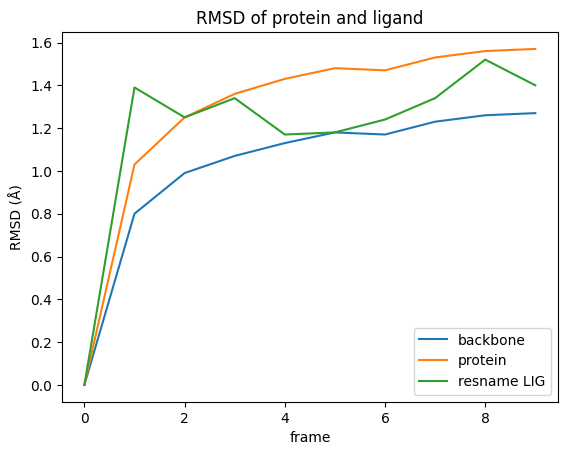

In [ ]:
rmsd.plot(title="RMSD of protein and ligand")
plt.ylabel("RMSD (Å)");

What can we see in the plot:

There are only slight conformational changes in the backbone during the simulation

The ligand move more freely and, additionally to any conformational changes, there might be directional movement involved.

RMSD between frames

In [ ]:
def RMSD_dist_frames(universe, selection):
    """Calculate the RMSD between all frames in a matrix.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection: str
        Selection string for the atomgroup to be investigated, also used during alignment.

    Returns
    -------
    array: np.ndarray
        Numpy array of RMSD values.
    """
    pairwise_rmsd = diffusionmap.DistanceMatrix(universe, select=selection)
    pairwise_rmsd.run()
    return pairwise_rmsd.results.dist_matrix

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dist_matrix_protein = RMSD_dist_frames(md_universe, "protein")
dist_matrix_ligand = RMSD_dist_frames(md_universe, f"resname {ligand_name}")
# get maximal distance between all frames
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


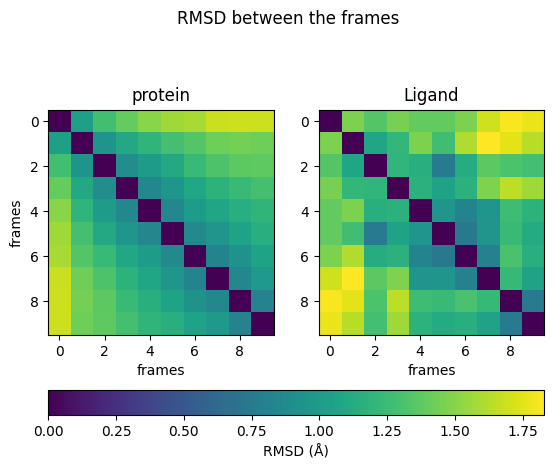

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("RMSD between the frames")

# protein image
img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("frames")
ax[0].set_ylabel("frames")

# ligand image
img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)");

Interaction analysis



Hydrogen Bond Analysis

In [20]:
import MDAnalysis as mda
import pandas as pd
import numpy as np

def compute_hydrogen_bonds_with_angles(u, ligand_selection, protein_selection, distance_cutoff=3.5, angle_cutoff=120.0):
    """
    Computes hydrogen bonds between ligand and protein using distance and angle criteria.

    Parameters
    ----------
    u : MDAnalysis.Universe
        MDAnalysis Universe object containing the trajectory.
    ligand_selection : str
        Atom selection string for the ligand.
    protein_selection : str
        Atom selection string for the protein.
    distance_cutoff : float
        Maximum distance (in Å) for hydrogen bond formation.
    angle_cutoff : float
        Minimum angle (in degrees) for hydrogen bond formation.

    Returns
    -------
    hbond_data : pandas.DataFrame
        DataFrame containing hydrogen bond information.
    """
    ligand = u.select_atoms(ligand_selection)
    protein = u.select_atoms(protein_selection)

    hbond_data = []

    for ts in u.trajectory:
        for donor in ligand:
            # Find hydrogen atoms attached to the donor
            hydrogens = donor.bonded_atoms.select_atoms("name H*")  # Assuming H atoms are named with "H"
            for hydrogen in hydrogens:
                for acceptor in protein:
                    # Compute distance
                    distance = np.linalg.norm(hydrogen.position - acceptor.position)
                    if distance <= distance_cutoff:
                        # Compute angle
                        donor_to_hydrogen = hydrogen.position - donor.position
                        hydrogen_to_acceptor = acceptor.position - hydrogen.position
                        cosine_angle = np.dot(donor_to_hydrogen, hydrogen_to_acceptor) / (
                            np.linalg.norm(donor_to_hydrogen) * np.linalg.norm(hydrogen_to_acceptor)
                        )
                        angle = np.degrees(np.arccos(cosine_angle))
                        if angle >= angle_cutoff:
                            hbond_data.append({
                                "frame": ts.frame,
                                "donor_index": donor.index,
                                "hydrogen_index": hydrogen.index,
                                "acceptor_index": acceptor.index,
                                "distance": distance,
                                "angle": angle
                            })

    return pd.DataFrame(hbond_data)

# Usage example
trajectory_file = "/content/drive/My Drive/MD_Lobetyolin_1BZL/trajectory.xtc"
topology_file = "/content/drive/My Drive/MD_Lobetyolin_1BZL/topology.pdb"

u = mda.Universe(topology_file, trajectory_file)
ligand_selection = "resname LIG"
protein_selection = "protein"

hbond_df = compute_hydrogen_bonds_with_angles(u, ligand_selection, protein_selection)
print(hbond_df.head())


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:295: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/usr/local/lib/python3.11/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


   frame  donor_index  hydrogen_index  acceptor_index  distance       angle
0      0         7498            7526             753  3.479514  133.544006
1      0         7504            7533             878  2.016212  122.343369
2      0         7510            7538            5143  3.498684  127.650658
3      0         7524            7552            3493  3.376111  132.984818
4      1         7502            7531            4436  3.279926  158.602905


Strong H bond interaction obsrved with 2.016 Å and 122.34° with donor 7504 and acceptor 878

In [31]:
donor_index = 7504  # Replace with your specific donor index
acceptor_index = 878  # Replace with your specific acceptor index

# Get atom objects for donor and acceptor
donor_atom = u.atoms[donor_index]
acceptor_atom = u.atoms[acceptor_index]

# Print residue information
print(f"Donor Atom: {donor_atom.name}, Residue: {donor_atom.resname}, Residue ID: {donor_atom.resid}")
print(f"Acceptor Atom: {acceptor_atom.name}, Residue: {acceptor_atom.resname}, Residue ID: {acceptor_atom.resid}")


Donor Atom: O3x, Residue: LIG, Residue ID: 1
Acceptor Atom: HZ2, Residue: LYS, Residue ID: 60


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
